<img src='images/Northwind_ERD_updated.png.'>

List of testing:
- One sample z test (know pop variance) - will not be able to test with this data
    - Kolmogorov-Smirnov Test
- One sample t test (don't know pop variance)
- Two way ANOVA
    - Tukey's (confirmatory)
- One Sample Proportion Testing
- Chi-Square
- Two Sample Proportion Testing/Two Sample Chi Square
- Bayesian Testing

# Question

### Does having a product on reorder increase spending? Is this connected to frieght?

Both questions can be tested using a paired sample t-test.

# Hypothesis

## H0: no effect - there is no change to spending based on reorder or frieght costs
## HA: there is an effect - there is a change to spending based on reorder or frieght costs

## Feature: spending
## Target: reorder/frieght

# Methodology

To evaluate the data provided by Northwind_ERD, I have chosen to use the following steps:
- Obtain Data
- Scrub Data
- Explore Data
- Modeling
- Interpret

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

# Obtain Data

The data we're evaluating comes from the 'Northwind_small.sqlite' file in this repository. We'll need to pull the following tables and the following lines of information:

- Product
    - ProductId
    - ReorderLevel
- Order
    - OrderId
    - ShipVia
    - Frieght
- OrderDetail
    - OrderId
    - ProductId
    - UnitPrice
    - Quantity

In [1]:
# import py file
from classes import pvalue

In [213]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('Solarize_Light2')
import seaborn as sns

idx = pd.IndexSlice

### Setting up the connection with the database

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

### Looking at the necessary data

In [4]:
# Order data
cur.execute("""SELECT *
               FROM 'Order';
               """)
df_order = pd.DataFrame(cur.fetchall())
df_order.columns = [x[0] for x in cur.description]
df_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [5]:
# OrderDetail data
cur.execute("""SELECT *, UnitPrice*Quantity as OrderTotal
               FROM OrderDetail;
               """)
df_orderdetail = pd.DataFrame(cur.fetchall())
df_orderdetail.columns = [x[0] for x in cur.description]
df_orderdetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [6]:
df_orderdetail['ProductId'].max()

77

In [7]:
# Product data
cur.execute("""SELECT *
               FROM Product;
               """)
df_product = pd.DataFrame(cur.fetchall())
df_product.columns = [x[0] for x in cur.description]
df_product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [8]:
# total number of prodcuts
len(df_product['ReorderLevel'])

77

In [9]:
# number of products without reorder
sum(df_product['ReorderLevel'] == 0)

24

In [10]:
df_product[df_product['ReorderLevel'] == 0]

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
7,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00,6,0,0,0
8,9,Mishi Kobe Niku,4,6,18 - 500 g pkgs.,97.00,29,0,0,1
9,10,Ikura,4,8,12 - 200 ml jars,31.00,31,0,0,0
11,12,Queso Manchego La Pastora,5,4,10 - 500 g pkgs.,38.00,86,0,0,0
13,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
16,17,Alice Mutton,7,6,20 - 1 kg tins,39.00,0,0,0,1
17,18,Carnarvon Tigers,7,8,16 kg pkg.,62.50,42,0,0,0
19,20,Sir Rodney's Marmalade,8,3,30 gift boxes,81.00,40,0,0,0


In [11]:
# number of products with a reorder
sum(df_product['ReorderLevel'] != 0)

53

In [12]:
df_product[df_product['ReorderLevel'] != 0]

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
5,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.00,120,0,25,0
6,7,Uncle Bob's Organic Dried Pears,3,7,12 - 1 lb pkgs.,30.00,15,0,10,0
10,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
12,13,Konbu,6,8,2 kg box,6.00,24,0,5,0
14,15,Genen Shouyu,6,2,24 - 250 ml bottles,15.50,39,0,5,0
15,16,Pavlova,7,3,32 - 500 g boxes,17.45,29,0,10,0
18,19,Teatime Chocolate Biscuits,8,3,10 boxes x 12 pieces,9.20,25,0,5,0


In [202]:
# All data
cur.execute("""SELECT 'Order'.Id, ShipVia, Freight, OrderDetail.UnitPrice*Quantity as ItemTotal, ReorderLevel
               FROM OrderDetail
               LEFT JOIN 'Order' ON OrderDetail.OrderID = 'Order'.Id
               JOIN Product ON OrderDetail.ProductId = Product.Id
               ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,ShipVia,Freight,ItemTotal,ReorderLevel
0,10248,3,32.38,168.0,30
1,10248,3,32.38,98.0,0
2,10248,3,32.38,174.0,0
3,10249,1,11.61,167.4,0
4,10249,1,11.61,1696.0,10


In [14]:
# total number of orders to be evaluated
len(df['Id'].unique())

830

In [191]:
table = pd.pivot_table(data=df, index=('Id', 'ShipVia', 'Freight', 'ReorderLevel'), aggfunc=sum,)
table.head()

ItemTotal
Id    ShipVia Freight ReorderLevel           
10248 3       32.38   0                 272.0
                      30                168.0
10249 1       11.61   0                 167.4
                      10               1696.0
10250 2       65.83   0                 252.0

In [196]:
df.columns

Index(['Id', 'ShipVia', 'Freight', 'ItemTotal', 'ReorderLevel'], dtype='object')

In [204]:
multi = df.copy(deep=True)
mulit = multi.set_index(['Id', 'ShipVia', 'Freight', 'ReorderLevel'], inplace=True)
multi.head()

ItemTotal
Id    ShipVia Freight ReorderLevel           
10248 3       32.38   30                168.0
                      0                  98.0
                      0                 174.0
10249 1       11.61   0                 167.4
                      10               1696.0

In [211]:
sort1 = multi.copy()
sort1.sort_index(inplace=True)
sort1.head(10)

ItemTotal
Id    ShipVia Freight ReorderLevel           
10248 3       32.38   0                  98.0
                      0                 174.0
                      30                168.0
10249 1       11.61   0                 167.4
                      10               1696.0
10250 2       65.83   0                 252.0
                      10                 77.0
                      10               1484.0
10251 1       41.34   0                 336.0
                      20                234.0

In [233]:
# only shipping for company 1
sort1.loc[idx[:, 1], idx['ItemTotal', 'ShipVia':'ShipVia']].sample(10)

TypeError: unhashable type: 'slice'

# Scrub Data

The following scrubbing techniques were applied to the original data:
- Manage n/a data types
- Delete duplicate rows
- Correct data types
- Find outliers

### Manage n/a data types

In [109]:
# nans identification
print(len(table))
table.isna().sum()

831


            ReorderLevel
ItemTotal   0               0
            5               0
            10              0
            15              0
            20              0
            25              0
            30              0
            All             0
OrderTotal                  0
dtype: int64

### Delete duplicate data

In [110]:
# identification of duplicate data
print('duplicated rows: ' + str(table.duplicated().sum()))

duplicated rows: 6


In [111]:
# code to drop duplicate rows
table.drop_duplicates(inplace=True)
print('duplicated rows: ' + str(table.duplicated().sum()))

duplicated rows: 0


### Correct data types

First, let's see what the data types for this data set are.

In [112]:
# data type identification
table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 825 entries, (10248, 3, 32.38) to (All, , )
Data columns (total 9 columns):
(ItemTotal, 0)      825 non-null float64
(ItemTotal, 5)      825 non-null float64
(ItemTotal, 10)     825 non-null float64
(ItemTotal, 15)     825 non-null float64
(ItemTotal, 20)     825 non-null float64
(ItemTotal, 25)     825 non-null float64
(ItemTotal, 30)     825 non-null float64
(ItemTotal, All)    825 non-null float64
(OrderTotal, )      825 non-null float64
dtypes: float64(9)
memory usage: 75.0+ KB


### Find outliers

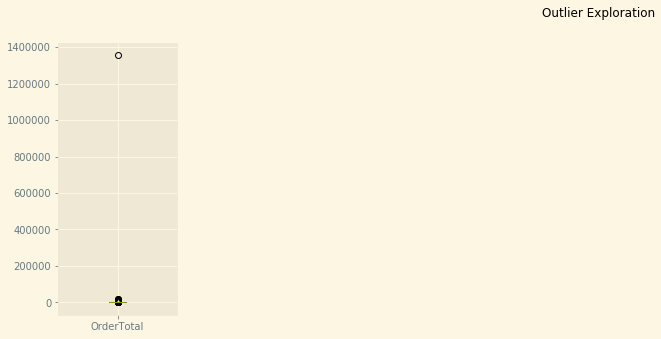

In [113]:
# outlier identification
fig01 = plt.figure(figsize=(20,5))
fig01.suptitle('Outlier Exploration')

ax = fig01.add_subplot(181)
ax1 = table.OrderTotal.plot(kind='box')

length of cleaner dataset: 824


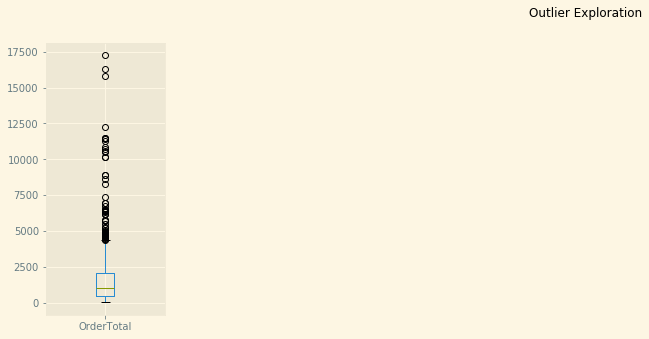

In [114]:
# management of outliers
table = table.loc[table['OrderTotal'] < 200000]
print('length of cleaner dataset: ' + str(len(table)))

fig02 = plt.figure(figsize=(20,5))
fig02.suptitle('Outlier Exploration')

ax = fig02.add_subplot(181)
ax1 = table.OrderTotal.plot(kind='box')

There seems to be quite a few outliers still. I'm hoping that an exploration will reveal them so that they can be removed.

# Explore Data

For a quick preview of what we have to work with, we'll use the describe method.

In [115]:
# describe data
table.describe()

ItemTotal                                          \
ReorderLevel             0            5           10            15   
count           824.000000   824.000000   824.000000    824.000000   
mean            717.289745    73.369539   142.006493    308.093374   
std            1222.172815   238.382355   413.725745   1329.706654   
min               0.000000     0.000000     0.000000      0.000000   
25%               0.000000     0.000000     0.000000      0.000000   
50%             252.000000     0.000000     0.000000      0.000000   
75%             938.475000     0.000000    59.650000    115.575000   
max           14421.900000  2808.000000  6360.000000  15810.000000   

                                                                   \
ReorderLevel           20           25           30           All   
count          824.000000   824.000000   824.000000    824.000000   
mean           104.558434   131.056189   163.944903   1640.318677   
std            275.424953   348.027315   440.223903   1995.054432   
min              0.000000     0.000000     0.000000     12.500000   
25%              0.000000     0.000000     0.000000    482.175000   
50%              0.000000     0.000000     0.000000   1025.000000   
75%             13.375000    57.000000    32.550000   2035.875000   
max           2485.000000  3420.000000  5268.000000  17250.000000   

                OrderTotal  
ReorderLevel                
count           824.000000  
mean           1643.318677  
std            1995.054432  
min              15.500000  
25%             485.175000  
50%            1028.000000  
75%            2038.875000  
max           17253.000000

Observations about df.describe()

### Visualize data

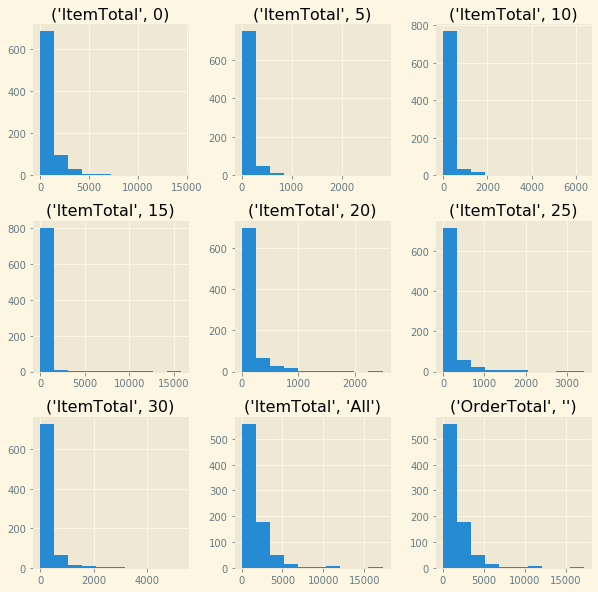

In [116]:
# visualize data
table.hist(figsize=(10,10));

This data looks like it needs a log transformation to be predictable. Alternatively, a non-parametric test could be used on the original data.

### Log Transformation

In [136]:
table

ItemTotal                                            \
ReorderLevel                  0     5       10    15     20     25     30   
Id    ShipVia Freight                                                       
10248 3       32.38      272.00   0.0     0.00   0.0    0.0    0.0  168.0   
10249 1       11.61      167.40   0.0  1696.00   0.0    0.0    0.0    0.0   
10250 2       65.83      252.00   0.0  1561.00   0.0    0.0    0.0    0.0   
10251 1       41.34      336.00   0.0     0.00   0.0  234.0  100.8    0.0   
10252 2       51.30     3680.00   0.0     0.00   0.0   50.0    0.0    0.0   
...                         ...   ...      ...   ...    ...    ...    ...   
11073 2       24.95       90.00   0.0     0.00   0.0    0.0    0.0  210.0   
11074 2       18.44        0.00   0.0   244.30   0.0    0.0    0.0    0.0   
11075 2       6.19       360.00   0.0     0.00   0.0   36.0  190.0    0.0   
11076 2       38.28      465.00  92.0     0.00   0.0    0.0  500.0    0.0   
11077 2       8.53       417.25  90.0    93.85  26.0   65.0  616.0   66.5   

                              OrderTotal  
ReorderLevel              All             
Id    ShipVia Freight                     
10248 3       32.38     440.0      443.0  
10249 1       11.61    1863.4     1866.4  
10250 2       65.83    1813.0     1816.0  
10251 1       41.34     670.8      673.8  
10252 2       51.30    3730.0     3733.0  
...                       ...        ...  
11073 2       24.95     300.0      303.0  
11074 2       18.44     244.3      247.3  
11075 2       6.19      586.0      589.0  
11076 2       38.28    1057.0     1060.0  
11077 2       8.53     1374.6     1377.6  

[824 rows x 9 columns]

In [133]:
# sort data
non_normal = [table['ItemTotal'][0], table['ItemTotal'][5], table['ItemTotal'][10], table['ItemTotal'][15], 
              table['ItemTotal'][20], table['ItemTotal'][25], table['ItemTotal'][30], 
              table['ItemTotal']['All'], table['OrderTotal']['OrderTotal']]
for feat in non_normal:
    table[feat] = table[feat].map(lambda x: np.log(x))
    
use applymap

NotImplementedError: Index._join_level on non-unique index is not implemented

Observations about sorted data

### Develop feature

In [ ]:
# create features
pass

# Model Data
Below is the model after scrubbing and exploring have been managed, let's see what the model picks up.

### Data normality

In [ ]:
# visual/code for data normality
pass

### Standard deviation

In [ ]:
# standard deviation for target variable
pass

### Basic testing

In [ ]:
# set up variables for this particular test
pass

In [ ]:
# test
pass

In [ ]:
# result
p_value = ''

In [ ]:
# evaluation of result
pass

Summarize results and determine next steps. Might include verification of sample size, error types, non-parametric testing, or a deepening of understanding

### Verification techniques
#### Non-parametric testing

In [ ]:
# non-parametric testing variables
pass

In [ ]:
# non-parametric test
pass

In [ ]:
# result
p_value = ''

In [ ]:
# evaluation of results
pass

Oberservations based on new finding

#### Effect size

In [ ]:
# effect size variables
pass

In [ ]:
# effect size test
pass

In [ ]:
# result
p_value = ''

In [ ]:
# evalation of result
pass

Obeservations about effect size

#### Power and error

In [ ]:
# power variables
pass

In [ ]:
# power test
pass

In [ ]:
# power result
p_value = ''

In [ ]:
# evaluation of power test
pass

Observations about power test

### Cross validatation

In [ ]:
# test train split for testing preformed above
pass

### Extension of acquired knowledge
#### Deeper question
#### Hypothesis for deeper question

In [ ]:
# deeper understanding variables
pass

In [ ]:
# deeper understanding test
pass

In [ ]:
# deeper understanding result
p_value = ''

In [ ]:
# deeper understanding evaluation of result
pass

Observations based off of deeper understanding test

# Interpret

Conclusions about question overall commentary on hypothesis

### Additional visualizations

In [ ]:
# visual for blah blah blah
pass

### Tools for use of discovered information

In [ ]:
# function or equation used to test developed theories
pass

# Future Work

give a list of options for future exploration opportunities

# Resources

give credit where it is due